## Setting Up



### Load libraries



Before we can use the libraries, we have to load them into our
environment.



In [2]:
library(tidyverse)
library(tidytext)
library(ggplot2)
library(topicmodels)
library(RColorBrewer)
library(LDAvis)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.3     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


### Load dataset



The data we will use is available for download as a CSV file from a
simple API created using Datasette. I have crafted a SQL query to get
just the data that we need. This query will return a table containing
each bill summary's unique ID in the database and its text.



In [3]:
data <- read.csv("https://llc.herokuapp.com/summaries.csv?sql=select%0D%0A++rowid%2C%0D%0A++content_text%0D%0Afrom%0D%0A++files%0D%0Awhere%0D%0A++%22path%22+like+%2274_2_s%25%22%0D%0Aorder+by%0D%0A++path&_size=max")
head(data)

,rowid,content_text
,<int>,<chr>
1,912,"S. 1016. Mr. Capper; January 15, 1935 (District of Columbia). Amending District of Columbia Code relative to opening of graves—Approved January 20, 1936 (Public, No. 421)."
2,1141,"S. 1019. Mr. King; January 15, 1935 (District of Columbia). As passed by the Senate, February 12, and referred to House Committee on the District of Columbia. February 15, 1935: Requires real estate brokers and salesmen in the District of Columbia (including nonresidents but excluding auctioneers, banks, trust companies, building and loan associations or land-mortgage or farm-loan associations) to secure annual licenses from a real estate commission hereby established (composed of three members—two appointed by the Commissioners and the assessor ex-officio). Applicants for licenses must be 21 years old, able to read and write English and must give proof of trustworthiness and competence in the business (not required if applicant has 2 years experience as a broker, etc., or in connection with real estate business in the District of Columbia). Bond required—$2,500 for brokers, $1,000 for salesmen—running to the District of Columbia; and a fee for broker’s license of $25 or $5 for salesman’s license. License may be revoked by the Commission, upon its own motion or on a verified complaint, after a hearing, for any fraudulent or dishonest dealing or conviction of a crime involving fraud or dishonesty. Revocation of a broker’s license suspends the license of every salesman under him."
3,1142,"S. 1077. Mr. McNary, January 16, 1935 (Irrigation and Reclamation). As passed by Senate, March 29, and reported by House Irrigation and Reclamation, May 13, 1935.— House Calendar No. 108: Extends to January 1, 1937, the time for the negotiation of a compact relating to apportionment of waters of the Columbia River [authorized originally by act of Mar. 4, 1925, between the States of Washington, Idaho, Oregon, and Montana, limited to Jan. 1. 1927; and subsequently extended to Dec. 1, 1927, by act of Apr. 13, 1926, to Dec. 31, 1930 by resolution of Mar. 3, 1927, and to Jan. 1, 1935, adding the State of Wyoming, by act of June 29, 1932—47 Stat. 381]."
4,1143,"S. 1095. Mr. Sheppard; January 16, 1935 (Military Affairs). As passed by Senate, February 6, and reported from House Military Affairs, April 1, 1935—Union Calendar No. 170. Gives to officers who served honorably in the Russian Railway Service Corps “during the war with Germany on and after April 6, 1917” the same status as honorably discharged emergency officers of the Army. [The Russian Railway Service Corps was organized by the Chief of Engineers, United States Army, at the request of the State Department, acting in turn on a request from the Russian Government. It was forwarded to Siberia in November 1917. Largely for their own protection, the members were constituted a semimilitary organization” with military titles and a special uniform.]"
5,1144,"S. 1116. Mr. Shipstead; January 16, 1935 (Library)—(Education and Labor, Feb. 15). As passed by Senate, June 10, 1935: Directs the Secretary of the Interior, through the Office of Education, to devise a comprehensive filing and indexing service for useful Government publications (Federal and Stale); and to furnish such service at cost to schools, libraries, and the general public. Necessary personnel (subject to civil-service laws) and appropriations are authorized. [Cf. H. R. 4015.]"
6,1145,"S. 1129. Mr. Connally; January 17, 1935 (Public Buildings and Grounds). As passed by Senate, April 9, and referred to House Public Buildings and Grounds, April 11, 1935: Authorizes the reconstruction at a total cost not exceeding $3,500,000 of the central portion of the Capitol Building, under direction of a commission composed of the President of the Senate and the Speaker, the Chairmen and ranking minority members of the two Committees on Public Buildings and Grounds, the minority leaders of the two Houses, and the Architect of the Capito

## A Little Exploration



We start by getting just the text of the bills.



In [4]:
text <- data %>% select(content_text)

### Tokenizing



The goal is to find a reasonable set of words to feed into the LDA
algorithm for topic modeling. We start by tokenizing the text of the
bill summaries.



In [5]:
tokens <- text %>% unnest_tokens(word, content_text)
data("stop_words")
tokens <- tokens %>% anti_join(stop_words)

Joining, by = "word"


And now we can take a quick look at the tokens that appear more than 100
times in the bill summaries.



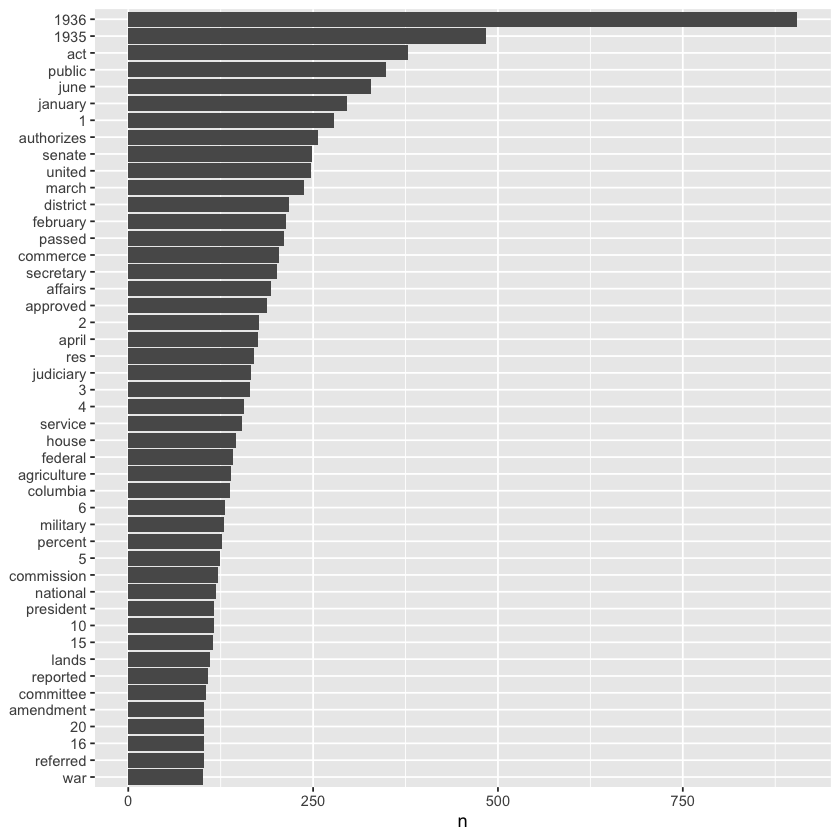

In [6]:
tokens %>%
  count(word, sort = TRUE) %>% 
  filter(n > 100) %>% 
  mutate(word = reorder(word, n)) %>% 
  ggplot(aes(n, word)) +
  geom_col() +
  labs(y = NULL)

There's a lot here that won't contribute to meaningful topic modeling,
specifically numbers and names of months. Let's get rid of those.



### Removing numbers and months



In [7]:
tokens <- tokens %>%
  filter(!grepl('[0-9]', word))

month_tokens <- tibble(month.name) %>% 
  unnest_tokens(word, month.name)

tokens <- tokens %>% anti_join(month_tokens)

Joining, by = "word"


### Token frequency without numbers and months



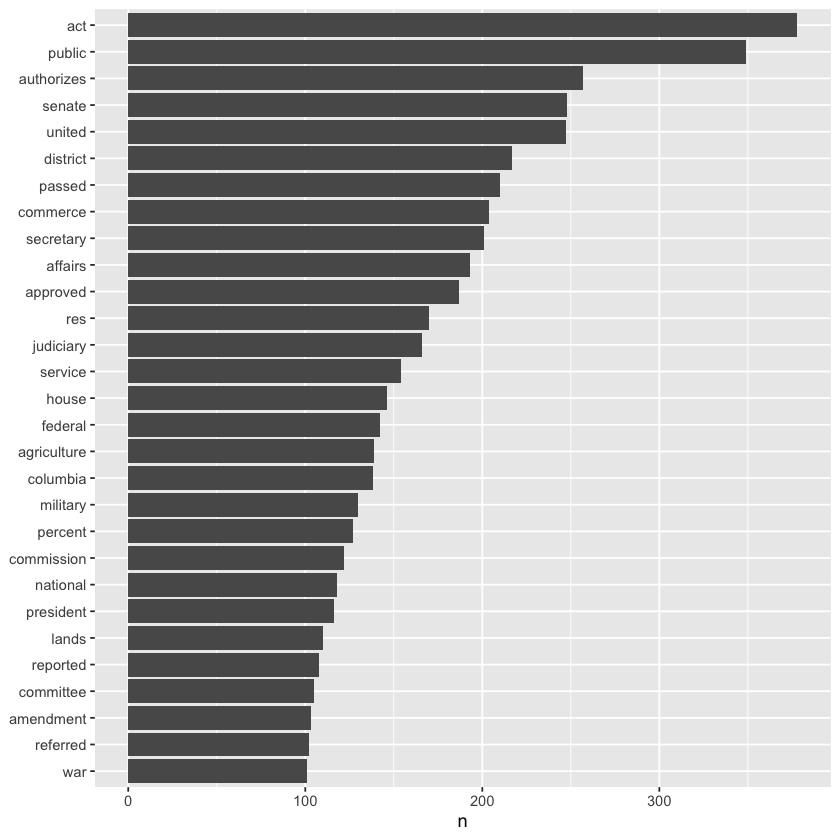

In [8]:
tokens %>%
  count(word, sort = TRUE) %>% 
  filter(n > 100) %>% 
  mutate(word = reorder(word, n)) %>% 
  ggplot(aes(n, word)) +
  geom_col() +
  labs(y = NULL)

This is better, but there's more we can do. First, let's remove so more
words that might clutter our model.



### Additional filters



In [9]:
bill_types <- read.csv("https://llc.herokuapp.com/summaries.csv?sql=select+distinct+bill_type+from+actions&_size=max")
sponsors <- read.csv("https://llc.herokuapp.com/summaries.csv?sql=select+distinct+sponsor+from+actions+where+sponsor+is+not+null+and+sponsor+%21%3D+%22%22&_size=max")
actions <- read.csv("https://llc.herokuapp.com/summaries.csv?sql=select+distinct+action+from+actions+where+action+is+not+null+and+action+%21%3D+%22%22+and+action+%21%3D+%22N%2FA%22&_size=max")

### More tokens



In [10]:
bill_type_tokens <- bill_types %>% 
  unnest_tokens(word, bill_type)
sponsor_tokens <- sponsors %>% 
  unnest_tokens(word, sponsor)
action_tokens <- actions %>% 
  unnest_tokens(word, action)

### Removing bill type and sponsor tokens



In [11]:
tokens <- tokens %>% 
  anti_join(bill_type_tokens) %>%
  anti_join(sponsor_tokens)

Joining, by = "word"
Joining, by = "word"


Another simple visualization



### Token frequency without bill types and sponsors



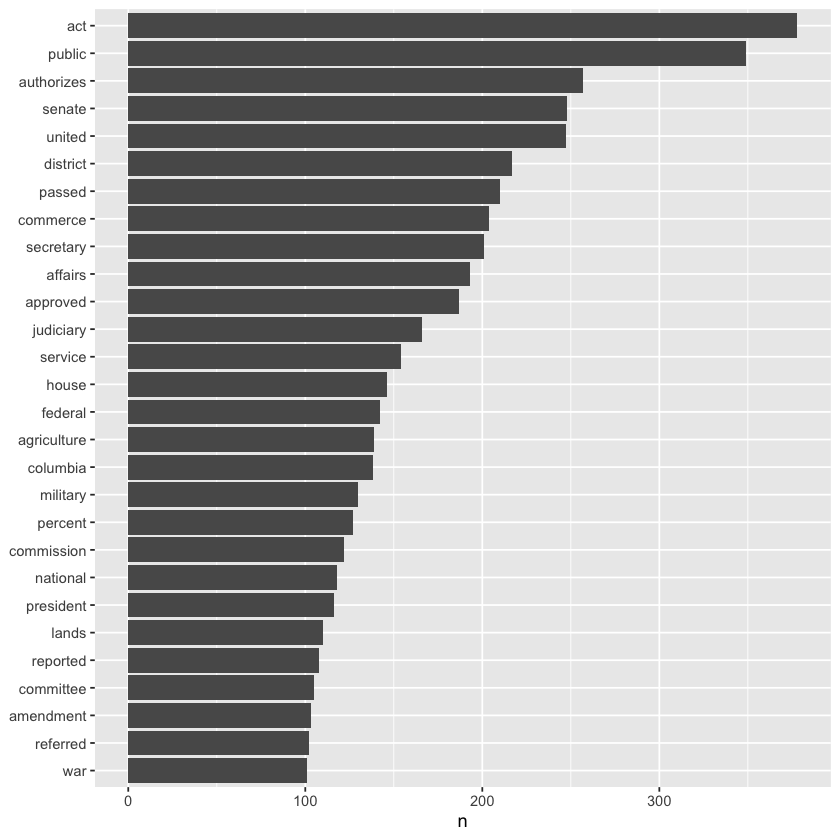

In [12]:
tokens %>%
  count(word, sort = TRUE) %>% 
  filter(n > 100) %>% 
  mutate(word = reorder(word, n)) %>% 
  ggplot(aes(n, word)) +
  geom_col() +
  labs(y = NULL)

Not much has changed here, but words like "approved", "reported", and
"referred" are terms for bill actions that won't contribute meaningfully
to the topic modeling algorithm. We'll remove them next.



### Removal:PROPERTIES:



In [13]:
distinct_action_tokens <- action_tokens %>% 
  distinct(word) %>% 
  filter(!grepl('[0-9]', word)) %>% 
  filter(!grepl('ed$|ly$', word)) %>% 
  anti_join(stop_words)

action_tokens_to_exclude <- action_tokens %>% 
  anti_join(distinct_action_tokens)

tokens <- tokens %>% 
 anti_join(action_tokens_to_exclude)

Joining, by = "word"
Joining, by = "word"
Joining, by = "word"


### Token frequency without bill types, sponsors, months, and action



tokens to exclude
Another quick bar chart



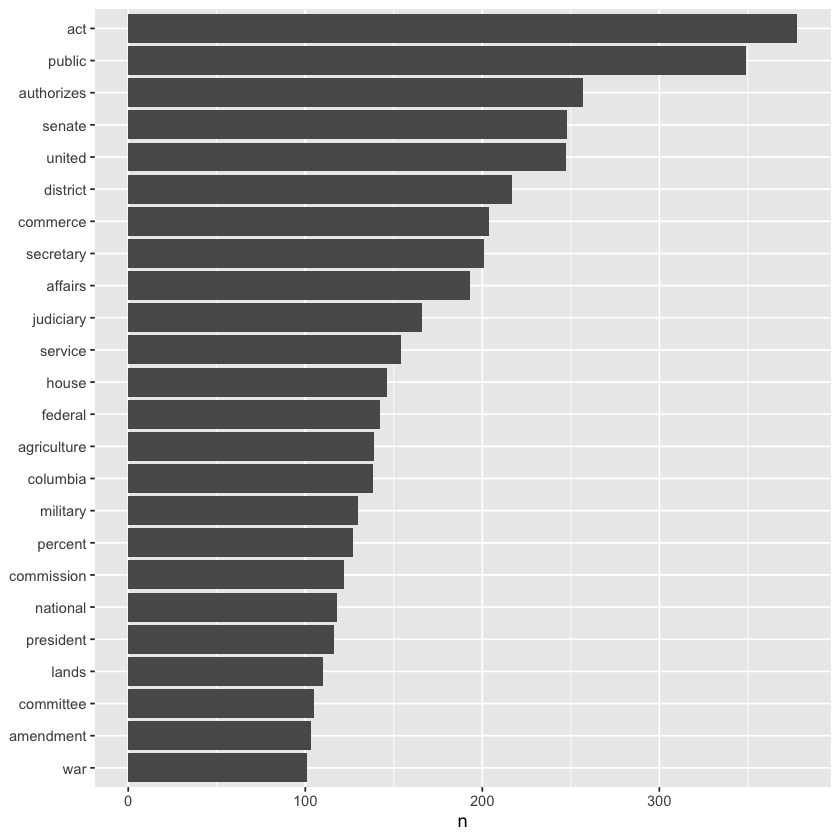

In [14]:
tokens %>%
  count(word, sort = TRUE) %>% 
  filter(n > 100) %>% 
  mutate(word = reorder(word, n)) %>% 
  ggplot(aes(n, word)) +
  geom_col() +
  labs(y = NULL)

This is enough to get going on topic modeling.



## Topic Modeling



We have to create a document term matrix for topic modeling. Luckily,
`tidytext` makes that very easy to do.

First, we get our tokens into the right shape for consumption by the
`cast_dtm` function.



In [15]:
tokens_for_dtm <- data %>% 
  unnest_tokens(word, content_text) %>% 
  filter(!grepl('[0-9]', word)) %>% 
  anti_join(stop_words) %>% 
  anti_join(month_tokens) %>% 
  anti_join(bill_type_tokens) %>%
  anti_join(sponsor_tokens) %>% 
  anti_join(action_tokens_to_exclude) %>% 
  count(rowid, word) %>% 
  mutate(document = rowid, term = word, count = n) %>% 
  select(document, term, count)

Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"
Joining, by = "word"


Next, we create our document term matrix.



In [16]:
senate_dtm <- tokens_for_dtm %>% 
  cast_dtm(document, term, count)

And now we can create our Latent Dirichlet Allocation object. k = 12 as
an arbitrary choice



In [17]:
senate_lda <- LDA(senate_dtm, k = 12, control = list(seed= 1234))

We can turn the topics generated by the LDA algorithm into tidy data for
exploration.



In [61]:
senate_topics <- tidy(senate_lda, matrix = "beta")

And we can pull out the top terms, based on the beta, or
[per-topic-per-word
probabilities](https://www.tidytextmining.com/topicmodeling.html#word-topic-probabilities), for each term.



In [62]:
senate_top_terms <- senate_topics %>% 
  group_by(topic) %>% 
  slice_max(beta, n = 10) %>% 
  ungroup() %>% 
  arrange(topic, -beta)

Let's see what we've got



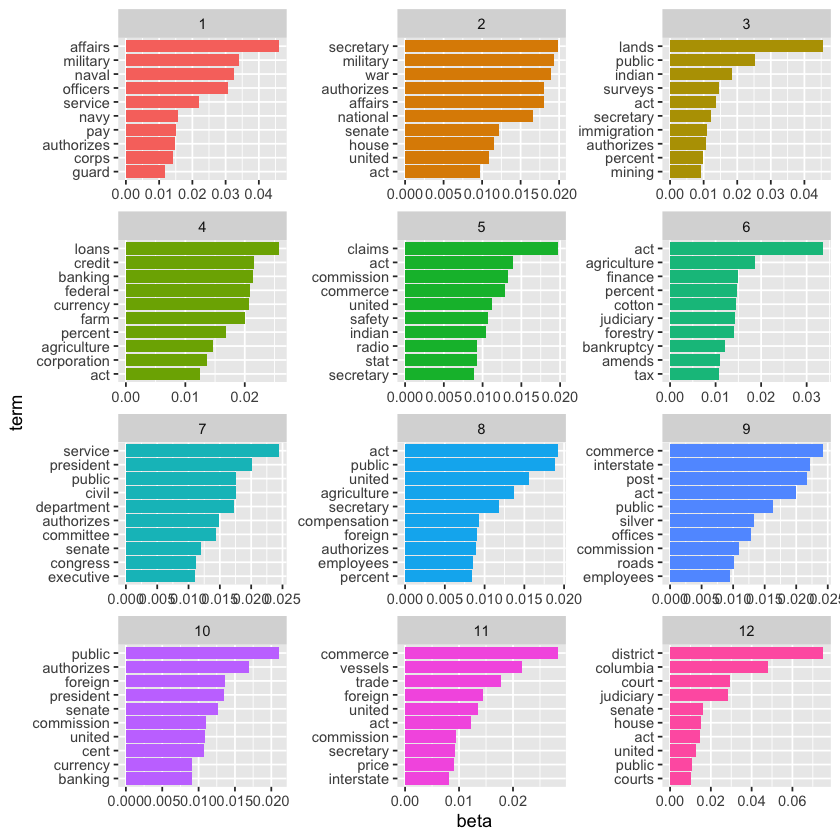

In [63]:
senate_top_terms %>% 
  mutate(term = reorder_within(term, beta, topic)) %>% 
  ggplot(aes(beta, term, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free", ncol = 3) +
  scale_y_reordered()

Some high frequency terms, like "act", "authorizes", and "public" are
cluttering our analysis. Let's sort the top terms by their beta and see
what we can get rid of.



In [64]:
top_terms_ordered <- senate_top_terms %>% arrange(desc(beta))
top_term_count <- top_terms_ordered %>% count(term) %>% arrange(desc(n))
top_term_count

term,n
<chr>,<int>
act,9
authorizes,6
public,6
united,6
secretary,5
commission,4
percent,4
senate,4
agriculture,3


Let's remove the ones that show up more than 5 times.



In [65]:
top_terms_to_remove <- top_term_count %>% filter(n > 5)
senate_top_terms <- senate_top_terms %>% anti_join(top_terms_to_remove)

Joining, by = "term"


And now let's take another look.



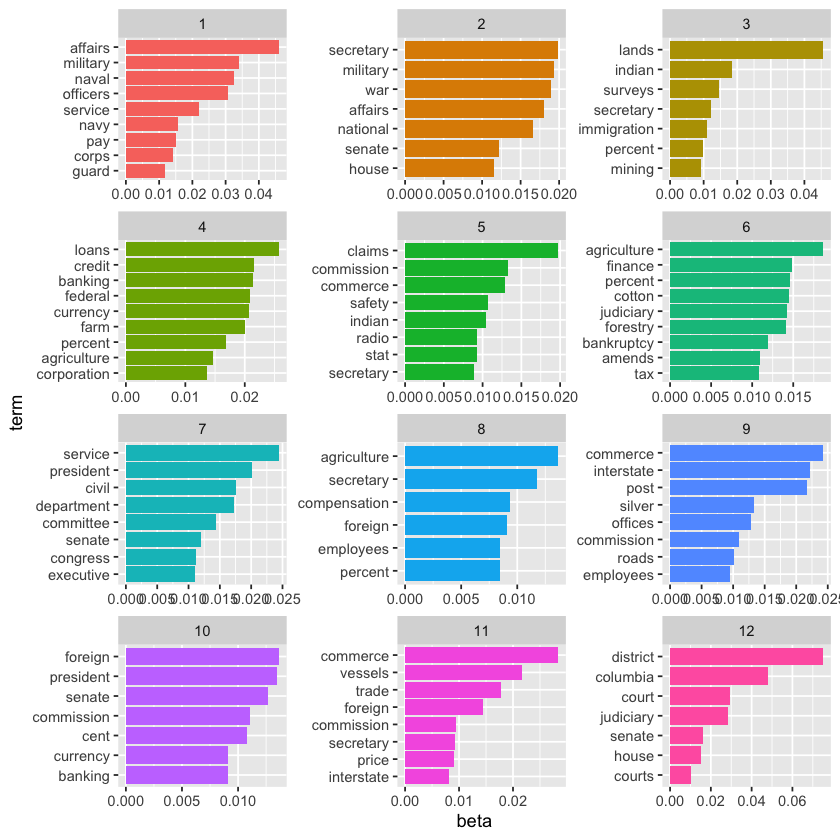

In [66]:
senate_top_terms %>% 
  mutate(term = reorder_within(term, beta, topic)) %>% 
  ggplot(aes(beta, term, fill = factor(topic))) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~ topic, scales = "free", ncol = 3) +
  scale_y_reordered()

## Further analysis



There were [48 Senate committees](https://en.wikipedia.org/wiki/74th_United_States_Congress#Committees) during the 74th Congress, so it could be interesting to change k to 48 in our call to `LDA()`. I don't yet know how to create an effective graphic with that many graphs, though, so it would be interesting to visualize `LDA()` with k = 48 in [LDAvis](https://github.com/cpsievert/LDAvis). This will require some data massaging I don't know how to do yet as the names of the columns in the output of `LDA()` are different from what LDAvis's `createJSON()` function expects as input.